## Data preprocessing
#### Tasks accomplished:
1. Use subset of data for segmentation
2. Split data into training, development and test set


In [1]:
import pandas as pd
import PIL as pil
import os
import random
from scipy.sparse import csr_matrix

import json
import numpy as np # linear algebra
from sklearn.model_selection import train_test_split

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import sample

Populating the interactive namespace from numpy and matplotlib


C:\Users\lloyd\anaconda3\envs\mlenv\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:

base_dir ='C:\\Users\\lloyd\\Desktop\\materialist2021'
df = pd.read_csv(base_dir+ '\\train.csv')
df

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317"
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317"
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204"
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219
...,...,...,...,...,...,...
333396,fffe20b555b98c3c1f26c8dfff275cbc,2712731 8 2715725 23 2718719 39 2721713 55 272...,3000,2001,28,163
333397,ffffbf7014a9e408bfbb81a75bc70638,71179 1 71678 3 72178 4 72678 4 73178 5 73679 ...,500,375,33,NaN
333398,ffffbf7014a9e408bfbb81a75bc70638,116648 5 117148 16 117648 22 118148 26 118647 ...,500,375,31,157
333399,ffffbf7014a9e408bfbb81a75bc70638,67711 1 68210 1 68709 2 69204 2 69208 3 69705 ...,500,375,31,157


In [3]:

new_labels = [ {'id': 0, 'name':'shirt','id_list':[0,1]},
    {'id': 1, 'name':'overcoat','id_list':[2,3,4,5,9]},
    {'id': 2, 'name':'pants','id_list':[6]},
    {'id':3, 'name': 'shorts','id_list':[7]},
    {'id':4,'name':'skirt','id_list':[8]},
    {'id':5,'name':'dress','id_list':[10]}]
json_object = json.dumps(new_labels, indent = 4) 
f = open(os.path.join(base_dir,"data","label_dict.json"),"w")

# write json object to file
f.write(json_object)

# close file
f.close()

new_labels_df = pd.DataFrame([(x['id'],y) for x in new_labels for y in x['id_list']],columns = ['new_id','old_id'])
new_labels_df.head()

,new_id,old_id
0,0,0
1,0,1
2,1,2
3,1,3
4,1,4


In [4]:
#update the classes
df = df[df.ClassId.isin(new_labels_df.old_id)]
df['ClassId'] = df.apply(lambda x: new_labels_df[new_labels_df.old_id.isin([x['ClassId']])].new_id.item(),axis = 1)


C:\Users\lloyd\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Find count of each class

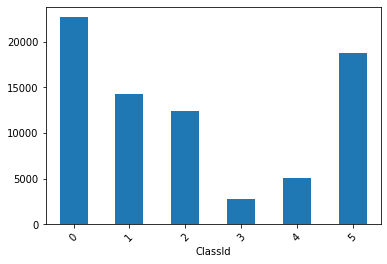

In [5]:
#find count of different classes in dataset
df_class_count = df.groupby(['ClassId']).count()['ImageId']
df_class_count.plot.bar(rot = 45)
plt.show()
df_class_count = df_class_count.sort_values()

In [6]:
df_class_count

ClassId
3     2756
4     5046
2    12414
1    14277
5    18739
0    22709
Name: ImageId, dtype: int64

#### Find list of unique images for each class id

In [7]:
df_class_image = df.groupby(['ClassId']).apply(lambda x: x['ImageId'].to_list())
df_class_image.head()

ClassId
0    [00000663ed1ff0c4e0132b9b9ac53f6e, 0000fe7c919...
1    [00000663ed1ff0c4e0132b9b9ac53f6e, 000aac3870e...
2    [00000663ed1ff0c4e0132b9b9ac53f6e, 000775b6b5e...
3    [000cd2e13d1bdd28f480304d7bb9e1ca, 00211c06b1f...
4    [00048c3a2fb9c29340473c4cfc06424a, 0006ea84499...
dtype: object

In [8]:
df_class_count_sample = df_class_count#[df_class_count <= 6000]
#df_class_count_sample = df_class_image.copy()
df_class_count_sample.index.to_list()
train = df.copy()

#### Split the images into training + development and test set
List of images for test set such that there are 25 images for each class. 
Many images have more than one class, therefore we start off with allocating images to classes with least number of images.

In [9]:

sample_len = 25
image_list = []
for i,val in df_class_count_sample.iteritems():
    
    class_image = df_class_image[i]
    existing_in_list = len(set(class_image) & set(image_list))
    sample_from = set(class_image) - set(image_list)
    
    if sample_len - existing_in_list > 0:
        
        image_list += sample(list(sample_from), sample_len - existing_in_list)
        
print("number of images: ",len(image_list))
    
test_set = train[train.ImageId.isin(image_list)][train.ClassId.isin(df_class_count_sample.index.to_list())]
train_dev_set = train[~(train.ImageId.isin(test_set.ImageId))][train.ClassId.isin(df_class_count_sample.index.to_list())]


number of images:  100


C:\Users\lloyd\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
C:\Users\lloyd\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


#### Repeat the above procedure to split images into training and development set

In [10]:
#find count of different classes in dataset
df_class_count = train_dev_set.groupby(['ClassId']).count()['ImageId']
df_class_count = df_class_count.sort_values()


In [11]:
sample_len = 25
image_list = []
df_class_image = train_dev_set.groupby(['ClassId']).apply(lambda x: x['ImageId'].to_list())

for i,val in df_class_count.iteritems():
    
    class_image = df_class_image[i]
    existing_in_list = len(set(class_image) & set(image_list))
    sample_from = set(class_image) - set(image_list)
    
    if sample_len - existing_in_list > 0:
        
        image_list += sample(list(sample_from), sample_len - existing_in_list)
        
print("number of images: ",len(image_list))
    
dev_set = train_dev_set[train_dev_set.ImageId.isin(image_list)]
train_set = train_dev_set[~(train_dev_set.ImageId.isin(dev_set.ImageId))]


number of images:  96


In [12]:
train_image_set = set(train_set.ImageId)
test_image_set = set(test_set.ImageId)
dev_image_set = set(dev_set.ImageId)
train_image_set.intersection(test_image_set,dev_image_set)

set()

In [13]:
base_dir ='C:\\Users\\lloyd\\Desktop\\materialist2021'

os.makedirs(os.path.join(base_dir,'train'))
os.makedirs(os.path.join(base_dir,'test'))
os.makedirs(os.path.join(base_dir,'dev'))

train_set.to_csv(os.path.join(base_dir,'train','train.csv'))
dev_set.to_csv(os.path.join(base_dir,'dev','dev.csv'))
test_set.to_csv(os.path.join(base_dir,'test','test.csv'))

copy_files_from = os.path.join(base_dir,'train')

import shutil

train_img_to = os.path.join(base_dir,'train')
dev_img_to = os.path.join(base_dir,'dev')
test_img_to = os.path.join(base_dir,'test')

train_img_list = train_set.ImageId.drop_duplicates()
dev_img_list = dev_set.ImageId.drop_duplicates()
test_img_list = test_set.ImageId.drop_duplicates()

for dev_img in dev_img_list:
    shutil.copy(os.path.join(copy_files_from,dev_img+'.jpg'),dev_img_to)

for test_img in test_img_list:
    shutil.copy(os.path.join(copy_files_from,test_img+'.jpg'),test_img_to)
    
for train_img in train_img_list:
    shutil.copy(os.path.join(copy_files_from,train_img+'.jpg'),train_img_to)
    


In [14]:
class_df = train_set.ClassId.drop_duplicates().reset_index(drop = True).reset_index()
class_df.set_index(['ClassId'],inplace = True)

In [15]:
train_set['ClassId'] = train_set.ClassId.apply(lambda x: class_df.loc[x].item())
dev_set['ClassId'] = dev_set.ClassId.apply(lambda x: class_df.loc[x].item())
test_set['ClassId'] = test_set.ClassId.apply(lambda x: class_df.loc[x].item())

C:\Users\lloyd\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\lloyd\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
train_set.to_csv(os.path.join(base_dir,'train','train.csv'))
dev_set.to_csv(os.path.join(base_dir,'dev','dev.csv'))
test_set.to_csv(os.path.join(base_dir,'test','test.csv'))